In [13]:
import os
import sys
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler,MinMaxScaler,StandardScaler,QuantileTransformer

import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import namedtuple

from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
full_name = 'Dmitry Polovnikov'
random_state = sum(map(ord,full_name))

In [5]:
MDATA_PATH = 'sirius_ml_labs-main-ps4-mdata/ps4/mdata'

In [6]:
def get_dates():
    return sorted(os.listdir(MDATA_PATH))

def get_tickers(date):
    return sorted(os.listdir(os.path.join(MDATA_PATH,date)))

dates = get_dates()

date_tickers = dict([(date,get_tickers(date)) for date in dates])
tickers = np.unique(np.concatenate(list(date_tickers.values()))).tolist()

def get_market_data(ticker):
    data = []
    for date in dates:
        if not os.path.exists(os.path.join(MDATA_PATH,date,ticker)):
            continue
        df = pd.read_csv(
            os.path.join(MDATA_PATH,date,ticker),
            compression='gzip',
            dtype={'bar_time':float,'TIMESTAMP':float},
            index_col=0,
            parse_dates=[2,3],
            date_parser=pd.to_datetime,
        )
        df.drop([
                'TIMESTAMP','WEEKDAY','MINUTE','HOUR','ZERO_SPREAD_ON_TRADE','EMPTY_LOB_SIDE_AFTER_UPDATE','NEGATIVE_SPREAD_AFTER_UPDATE',
                'ZERO_SPREAD_AFTER_UPDATE','EMPTY_LOB_SIDE_ON_TRADE','NEGATIVE_SPREAD_ON_TRADE','bar_count','BAR_DURATION'
            ], axis = 1, inplace = True
        )
        df = df[df.columns[~df.columns.str.startswith('EXEC')]]
        data.append(df)
    data = pd.concat(data).set_index('bar_time').sort_index()
    
    price_grid = data.filter(like='PRICE_GRID')
    vol_grid = data.filter(like='VOL_GRID')
    
    data = data[ data.columns[ ~data.columns.str.startswith('PRICE_GRID') & ~data.columns.str.startswith('VOL_GRID') ] ]
    
    return data,price_grid,vol_grid

In [7]:
ticker = 'Z.DOGE'

In [8]:
mdata,pgrid,vgrid = get_market_data(ticker)
mdata = mdata.groupby(mdata.index).last()

/tmp/ipykernel_2352510/2711608588.py:17: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(
/tmp/ipykernel_2352510/2711608588.py:17: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(
/tmp/ipykernel_2352510/2711608588.py:17: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(
/tmp/ipykernel_2352510/2711608588.py:17: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then 

In [9]:
returns_ahead = mdata['LAST'].pct_change().shift(-1).fillna(0)

# EXCLUDING NON-STATIONARY DATA HARD-CODED.
mdata.drop(['BEST_BID','BEST_ASK','LAST','HIGH','LOW','VWAP'],axis=1,inplace=True)

In [10]:
mdata

,BEST_BID_VOL,BEST_ASK_VOL,VOLUME,DVOL,ENTROPY,COUNT,COUNT_BUY,COUNT_SELL,MO_COUNT,MO_COUNT_BUY,MO_COUNT_SELL,MO_AVG,MO_AVG_BUY,MO_AVG_SELL,BREAK_BEST_DOWN,BREAK_BEST_UP,ASK_VOLUME,BID_VOLUME
bar_time,,,,,,,,,,,,,,,,,,
2021-01-01 00:02:01.217999872,471032.0,863661.0,2050729.0,739011.0,2.678179,67.0,49.0,18.0,46.0,32.0,14.0,44581.065217,43589.687500,46847.071429,18.0,17.0,32842275.0,54135632.0
2021-01-01 00:05:06.065999872,653997.0,162062.0,1126090.0,-732448.0,2.188727,37.0,7.0,30.0,22.0,5.0,18.0,51185.909091,39364.200000,51626.055556,26.0,20.0,34781376.0,51456498.0
2021-01-01 00:08:29.527000064,96024.0,1034125.0,7149018.0,-1300820.0,3.392892,187.0,44.0,143.0,79.0,27.0,52.0,90493.898734,108299.962963,81248.442308,45.0,15.0,43340642.0,51240202.0
2021-01-01 00:10:31.216999936,25436.0,35278.0,4018384.0,-2843590.0,2.695272,118.0,31.0,87.0,59.0,27.0,32.0,68108.203390,21755.444444,107218.343750,37.0,22.0,29911119.0,51185141.0
2021-01-01 00:12:11.052999936,316022.0,308006.0,5627600.0,3455126.0,2.826839,134.0,80.0,54.0,52.0,23.0,29.0,108223.076923,197450.565217,37456.448276,36.0,24.0,39424065.0,57641628.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-31 23:37:08.680000000,893.0,25707.0,11079816.0,884774.0,4.144715,5207.0,2437.0,2770.0,1956.0,966.0,991.0,5664.527607,6192.851967,5143.815338,545.0,488.0,113225574.0,176129565.0
2021-10-31 23:42:08.324000000,73561.0,8280.0,19140401.0,-1601367.0,4.605169,7469.0,2879.0,4590.0,2689.0,1243.0,1447.0,7118.036817,7055.122285,7167.162405,514.0,529.0,114849594.0,176892489.0
2021-10-31 23:47:08.182000128,24218.0,10852.0,20350198.0,-4369524.0,4.976540,8462.0,2961.0,5501.0,2773.0,1262.0,1511.0,7338.693833,6331.487322,8179.921244,595.0,604.0,114744021.0,177170927.0


In [11]:
n_features = mdata.shape[1]
n_features

18

In [14]:
# split to train-test chronologically

os_index_start = int(0.8*mdata.shape[0])

X_train, X_test = mdata.iloc[:os_index_start].values,mdata.iloc[os_index_start:].values
y_train, y_test = returns_ahead.iloc[:os_index_start].values,returns_ahead.iloc[os_index_start:].values

# within the train set split to real-train and validation sets
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=random_state)

In [63]:
fct = QuantileTransformer()
fct.fit(X_train)
X_train_fct,X_val_fct,X_test_fct = fct.transform(X_train),fct.transform(X_val),fct.transform(X_test)

tct = QuantileTransformer()
tct.fit(y_train.reshape((y_train.size,1)))
y_train_tct,y_val_tct,y_test_tct = tct.transform(y_train.reshape((y_train.size,1))).flatten(),tct.transform(y_val.reshape((y_val.size,1))).flatten(),tct.transform(y_test.reshape((y_test.size,1))).flatten()

In [65]:
X_train_fct_t = torch.tensor(X_train_fct,dtype=torch.float32,device=DEVICE)
y_train_tct_t = torch.tensor(y_train_tct,dtype=torch.float32,device=DEVICE)

X_val_fct_t = torch.tensor(X_val_fct,dtype=torch.float32,device=DEVICE)
y_val_tct_t = torch.tensor(y_val_tct,dtype=torch.float32,device=DEVICE)

X_test_fct_t = torch.tensor(X_test_fct,dtype=torch.float32,device=DEVICE)
y_test_tct_t = torch.tensor(y_test_tct,dtype=torch.float32,device=DEVICE)

In [19]:
DEVICE = 'cpu'

In [21]:
# MMF - market microstructure features
MMFEpisode = namedtuple('MMFEpisode',['features','targets'])

In [22]:
class MMFSet(torch.utils.data.Dataset):
    def __init__(self,X,y,episode_len):
        super().__init__()
        
        assert X.shape[0] == y.size
        
        self.n_ticks,self.n_features = X.shape
        self.episode_len = episode_len
        self.features_t = torch.tensor(X,dtype=torch.float32,device=DEVICE)
        self.targets_t = torch.tensor(y,dtype=torch.float32,device=DEVICE)
    
    def __len__(self):
        return self.n_ticks-self.episode_len+1
    
    def __getitem__(self,i):
        return MMFEpisode(
            features = self.features_t[i:i+self.episode_len],
            targets = self.targets_t[i:i+self.episode_len]
        )

#### FIRST HYPERPARAMS ITERATION

In [28]:

EPISODE_LEN = 256
HIDDEN_SIZE_0 = 64
HIDDEN_SIZE_1 = 64
BATCH_SIZE = 128
LEARNING_RATE = 0.01


In [29]:
mmf_train_set = MMFSet(X_train_fct,y_train_tct,EPISODE_LEN)

In [30]:
# LSTM - long short-term memory

class MMFLSTM(nn.Module):
    def __init__(self,input_size,hidden_size_0,hidden_size_1):
        super().__init__()
        
        self.lstm = nn.LSTM(input_size=input_size,hidden_size=hidden_size_0)
        self.linear_0 = nn.Linear(hidden_size_0,hidden_size_1)
        self.linear_1 = nn.Linear(hidden_size_1,1)
        
    def forward(self,x):
        lstm_out,(hidden,cell) = self.lstm.forward(x)
        lin_0_out = self.linear_0.forward(lstm_out)
        lin_0_out = torch.relu(lin_0_out)
        lin_1_out = self.linear_1.forward(lin_0_out)
        
        return lin_1_out

In [31]:
mmf_lstm = MMFLSTM(n_features,HIDDEN_SIZE_0,HIDDEN_SIZE_1)

mmf_loss_fn = F.mse_loss
mmf_optimizer = torch.optim.Adam(mmf_lstm.parameters(),lr=LEARNING_RATE)

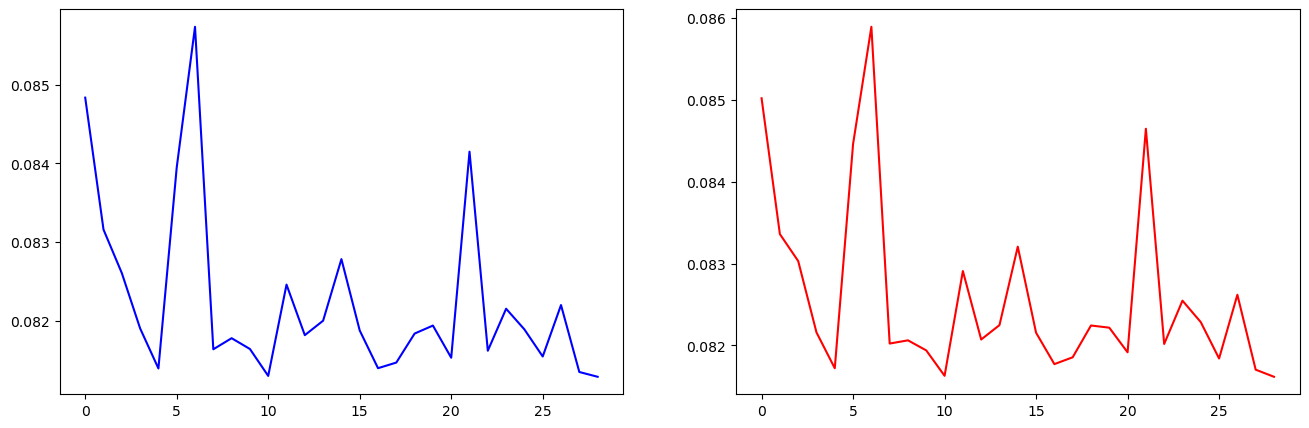

KeyboardInterrupt: 

In [32]:
train_loss_hist = []
val_loss_hist = []

iter_num = 0
for epoch in range(100):
    mmf_train_batch_set = torch.utils.data.DataLoader(
        mmf_train_set,
        batch_size = BATCH_SIZE,
        shuffle = False,
    )

    for mmf_episode in mmf_train_batch_set:
        iter_num += 1
        
        predicted_targets = mmf_lstm(mmf_episode.features)[:,:,0]
        train_loss = mmf_loss_fn(predicted_targets,mmf_episode.targets)

        mmf_lstm.zero_grad()
        train_loss.backward()
        mmf_optimizer.step()
        
        if not iter_num % 20:
            mmf_lstm.train(False)
            
            train_loss = mmf_loss_fn(mmf_lstm(X_train_fct_t)[:,0],y_train_tct_t)
            train_loss_hist.append(train_loss.item())
            
            val_loss = mmf_loss_fn(mmf_lstm(X_val_fct_t)[:,0],y_val_tct_t)
            val_loss_hist.append(val_loss.item())
            
            mmf_lstm.train(True)
            
            clear_output(True)

            tlh = pd.Series(train_loss_hist)
            vlh = pd.Series(val_loss_hist)

            fig,axs = plt.subplots(1,2,figsize=(16,5))
            axs[0].plot(tlh.index,tlh.values,label='train loss',color='blue')
            axs[1].plot(vlh.index,vlh.values,label='val loss',color='red')

            plt.show()

#### SECOND HYPERPARAMS ITERATION

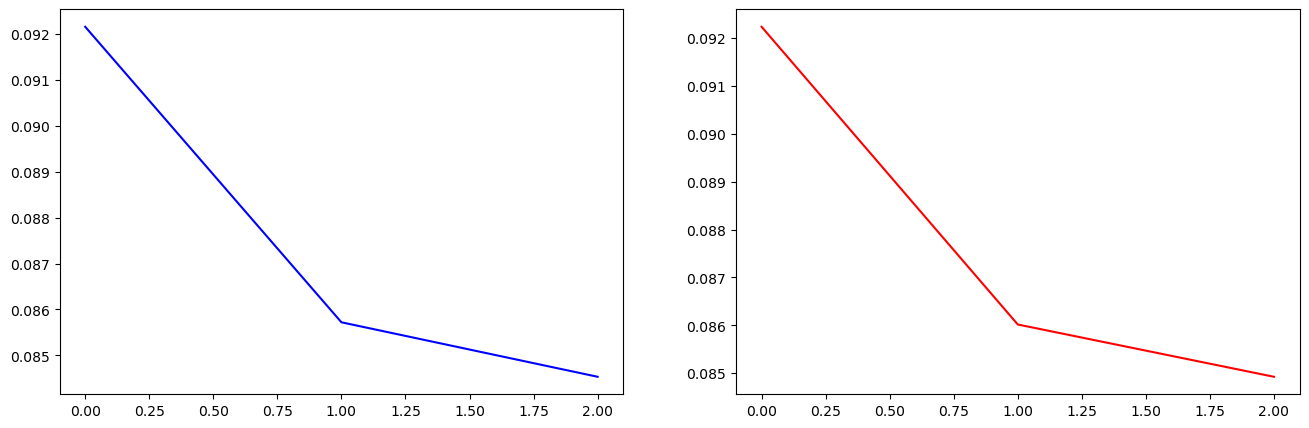

In [ ]:

EPISODE_LEN = 256
HIDDEN_SIZE_0 = 128
HIDDEN_SIZE_1 = 128
BATCH_SIZE = 256
LEARNING_RATE = 0.001

mmf_train_set = MMFSet(X_train_fct,y_train_tct,EPISODE_LEN)

#=====#

mmf_lstm = MMFLSTM(n_features,HIDDEN_SIZE_0,HIDDEN_SIZE_1)

mmf_loss_fn = F.mse_loss
mmf_optimizer = torch.optim.Adam(mmf_lstm.parameters(),lr=LEARNING_RATE)

#=====#

train_loss_hist = []
val_loss_hist = []

iter_num = 0
epochs = 30
for epoch in range(epochs):
    print(f'Epoch = {epoch}')
    mmf_train_batch_set = torch.utils.data.DataLoader(
        mmf_train_set,
        batch_size = BATCH_SIZE,
        shuffle = False,
    )
    
    mmf_optimizer = torch.optim.Adam(
        mmf_lstm.parameters(),lr=LEARNING_RATE * np.exp(-epoch/epochs))

    for mmf_episode in mmf_train_batch_set:
        iter_num += 1
        
        predicted_targets = mmf_lstm(mmf_episode.features)[:,:,0]
        train_loss = mmf_loss_fn(predicted_targets,mmf_episode.targets)

        mmf_lstm.zero_grad()
        train_loss.backward()
        mmf_optimizer.step()
        
        if not iter_num % 20:
            mmf_lstm.train(False)
            
            train_loss = mmf_loss_fn(mmf_lstm(X_train_fct_t)[:,0],y_train_tct_t)
            train_loss_hist.append(train_loss.item())
            
            val_loss = mmf_loss_fn(mmf_lstm(X_val_fct_t)[:,0],y_val_tct_t)
            val_loss_hist.append(val_loss.item())
            
            mmf_lstm.train(True)
            
            clear_output(True)

            tlh = pd.Series(train_loss_hist)
            vlh = pd.Series(val_loss_hist)

            fig,axs = plt.subplots(1,2,figsize=(16,5))
            axs[0].plot(tlh.index,tlh.values,label='train loss',color='blue')
            axs[1].plot(vlh.index,vlh.values,label='val loss',color='red')

            plt.show()

#### THIRD HYPERPARAMS ITERATION

In [ ]:

EPISODE_LEN = 64
HIDDEN_SIZE_0 = 128
HIDDEN_SIZE_1 = 256
BATCH_SIZE = 64
LEARNING_RATE = 0.01

mmf_train_set = MMFSet(X_train_fct,y_train_tct,EPISODE_LEN)

#=====#

mmf_lstm = MMFLSTM(n_features,HIDDEN_SIZE_0,HIDDEN_SIZE_1)

mmf_loss_fn = F.mse_loss
mmf_optimizer = torch.optim.Adam(mmf_lstm.parameters(),lr=LEARNING_RATE)

#=====#

train_loss_hist = []
val_loss_hist = []

iter_num = 0
epochs = 30
for epoch in range(epochs):
    print(f'Epoch = {epoch}')
    mmf_train_batch_set = torch.utils.data.DataLoader(
        mmf_train_set,
        batch_size = BATCH_SIZE,
        shuffle = False,
    )
    
    mmf_optimizer = torch.optim.Adam(
        mmf_lstm.parameters(),lr=LEARNING_RATE * np.exp(-epoch/epochs))

    for mmf_episode in mmf_train_batch_set:
        iter_num += 1
        
        predicted_targets = mmf_lstm(mmf_episode.features)[:,:,0]
        train_loss = mmf_loss_fn(predicted_targets,mmf_episode.targets)

        mmf_lstm.zero_grad()
        train_loss.backward()
        mmf_optimizer.step()
        
        if not iter_num % 20:
            mmf_lstm.train(False)
            
            train_loss = mmf_loss_fn(mmf_lstm(X_train_fct_t)[:,0],y_train_tct_t)
            train_loss_hist.append(train_loss.item())
            
            val_loss = mmf_loss_fn(mmf_lstm(X_val_fct_t)[:,0],y_val_tct_t)
            val_loss_hist.append(val_loss.item())
            
            mmf_lstm.train(True)
            
            clear_output(True)

            tlh = pd.Series(train_loss_hist)
            vlh = pd.Series(val_loss_hist)

            fig,axs = plt.subplots(1,2,figsize=(16,5))
            axs[0].plot(tlh.index,tlh.values,label='train loss',color='blue')
            axs[1].plot(vlh.index,vlh.values,label='val loss',color='red')

            plt.show()

#### CONSTRUCT PNL ON LSTM PREDICTION

In [80]:
y_predictions = mmf_lstm(X_test_fct_t).detach().numpy()
y_predictions = tct.inverse_transform(y_predictions).reshape(-1)

In [83]:
y_predictions.shape , y_test.shape

((66396,), (66396,))

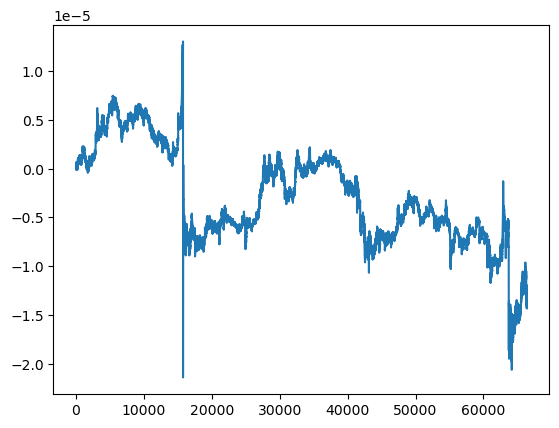

In [84]:
pnl = (y_predictions * y_test).cumsum()
plt.plot(pnl)